# Inpainting using Dall-E
Inpainting is the task of replacing a selected part of an image by generated pixels that make the selection disappear. When working with scientific images, this could be seen as scientific misconduct. Be careful when applying this technique to your microscopy images.

In this notebook we will use [Dall-E 2](https://openai.com/dall-e-2) to inpaint a region of an image.

In [1]:
from skimage.io import imread
import stackview
import numpy as np

In [2]:
def replace(input_image, mask = None, prompt:str = "A similar pattern like in the rest of the image", image_width:int=1024, image_height:int=1024, model="dall-e-2"):
    """
    Replace a masked region in an image with a new pattern as described in a prompt using OpenAI's DALL-E.

    Parameters
    ----------
    input_image: 2D image, potentially RGB
    mask: 2D image, optional
    prompt: str, optional
    image_width: int, optional
        must be 256, 512 or 1024 for dall-e-2
    image_height: int, optional
        must be 256, 512 or 1024 for dall-e-2
    model: str, optional
        model name, e.g. "dall-e-2"

    See Also
    --------
    https://platform.openai.com/docs/guides/images/edits

    Returns
    -------
    single 2D image or 3D image with the first dimension = num_images
    """
    from image_utilities import numpy_to_bytestream, images_from_url_responses
    from stackview._image_widget import _img_to_rgb
    from skimage import transform
    import numpy as np
    from openai import OpenAI
    from warnings import warn

    warn("Using the replace function on scientific images could be seen as scientific misconduct. Handle this function with care.")

    # we rescale image and mask to the specified size
    resized_image = transform.resize(input_image, (image_height, image_width), anti_aliasing=True)
    resized_mask = transform.resize(mask, (image_height, image_width), anti_aliasing=False)

    resized_image_rgb = _img_to_rgb(resized_image)
    resized_image_rgb = (resized_image_rgb * 255 / resized_image_rgb.max()).astype(np.uint8)
    
    # We store the mask in the alpha-channel of a new RGBA image
    masked_rgba = (np.swapaxes(np.swapaxes(np.asarray([
        resized_image_rgb[:, :, 0],
        resized_image_rgb[:, :, 1],
        resized_image_rgb[:, :, 2],
        (resized_mask == 0) * 255]), 0, 2), 0, 1)).astype(np.uint8)

    # actual request to OpenAI's DALL-E
    client = OpenAI()

    response = client.images.edit(
      image=numpy_to_bytestream(resized_image_rgb),
      mask=numpy_to_bytestream(masked_rgba),
      prompt=prompt,
      n=1,
      size=f"{image_width}x{image_height}",
      model=model
    )

    # bring result in right format
    return images_from_url_responses(response, input_image.shape)
    

In this example we aim to replace the cell in the lower middle of this image.

StackViewNDArray([[[ 3,  6,  1],
                   [ 3,  7,  0],
                   [ 3,  6,  1],
                   ...,
                   [11,  8,  2],
                   [11,  7,  2],
                   [11, 11,  2]],

                  [[ 3,  6,  1],
                   [ 3,  8,  1],
                   [ 3,  7,  1],
                   ...,
                   [11, 10,  2],
                   [10, 10,  2],
                   [11, 11,  2]],

                  [[ 4,  6,  1],
                   [ 3,  6,  1],
                   [ 4,  6,  1],
                   ...,
                   [10, 10,  2],
                   [11, 10,  2],
                   [11, 10,  2]],

                  ...,

                  [[15, 14,  8],
                   [14, 14,  8],
                   [15, 14,  7],
                   ...,
                   [10, 11,  5],
                   [10, 12,  4],
                   [11, 14,  5]],

                  [[14, 16,  7],
                   [16, 15,  7],
                   [15, 16,  8],
                   ...,
                   [10, 11,  4],
                   [11, 13,  4],
                   [11, 16,  5]],

                  [[15, 18,  7],
                   [14, 17,  8],
                   [14, 17,  8],
                   ...,
                   [ 9, 12,  5],
                   [10, 13,  5],
                   [11, 15,  5]]], dtype=uint8)
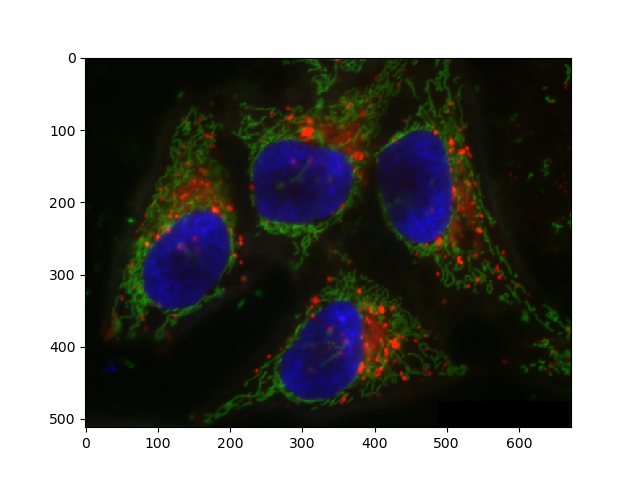
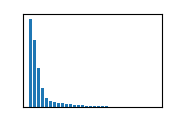

In [3]:
input_image = imread("data/hela-cells-8bit.tif")

stackview.insight(input_image)

We mark this cell using a binary mask.

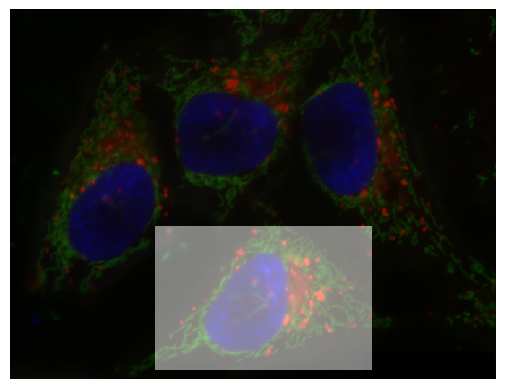

In [4]:
mask = np.zeros(input_image.shape[:2], dtype=np.uint8)
mask[300:500, 200:500] = 1

stackview.imshow(input_image, continue_drawing=True)
stackview.imshow(mask, alpha=0.5)

We then call the `replace` function to generate a new image.

C:\Users\haase\AppData\Local\Temp\ipykernel_15552\3332187937.py:32: UserWarning: Using the replace function on scientific images could be seen as scientific misconduct. Handle this function with care.
  warn("Using the replace function on scientific images could be seen as scientific misconduct. Handle this function with care.")


StackViewNDArray([[[ 3,  6,  0],
                   [ 3,  6,  0],
                   [ 3,  6,  0],
                   ...,
                   [10,  8,  2],
                   [10,  7,  2],
                   [10,  9,  2]],

                  [[ 3,  6,  0],
                   [ 3,  6,  0],
                   [ 3,  6,  0],
                   ...,
                   [10,  9,  2],
                   [10,  9,  2],
                   [10,  9,  2]],

                  [[ 3,  6,  0],
                   [ 3,  6,  0],
                   [ 3,  6,  0],
                   ...,
                   [10,  9,  2],
                   [10,  9,  2],
                   [10,  9,  2]],

                  ...,

                  [[13, 14,  6],
                   [13, 14,  6],
                   [14, 14,  7],
                   ...,
                   [ 8,  9,  3],
                   [ 9, 11,  3],
                   [ 9, 12,  3]],

                  [[14, 15,  7],
                   [14, 14,  7],
                   [14, 15,  7],
                   ...,
                   [ 9, 10,  3],
                   [ 9, 12,  4],
                   [ 9, 14,  4]],

                  [[14, 16,  7],
                   [14, 16,  7],
                   [14, 15,  7],
                   ...,
                   [ 9, 11,  3],
                   [ 9, 12,  4],
                   [10, 14,  4]]], dtype=uint8)
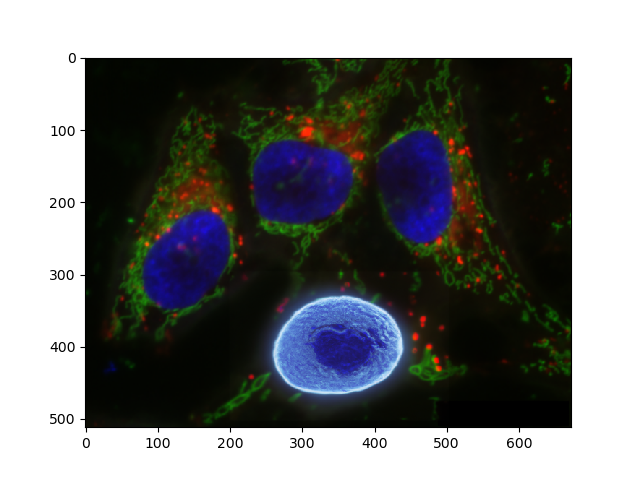
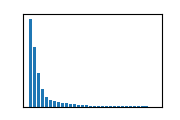

In [7]:
new_image = replace(input_image, mask, prompt="a cell with one dark blue nucleus.")

stackview.insight(new_image)

C:\Users\haase\mambaforge\envs\tea4\lib\site-packages\stackview\_animate.py:61: UserWarning: The image is quite large (> 10 MByte) and might not be properly shown in the notebook when rendered over the internet. Consider subsampling or cropping the image for visualization purposes.
  warnings.warn("The image is quite large (> 10 MByte) and might not be properly shown in the notebook when rendered over the internet. Consider subsampling or cropping the image for visualization purposes.")



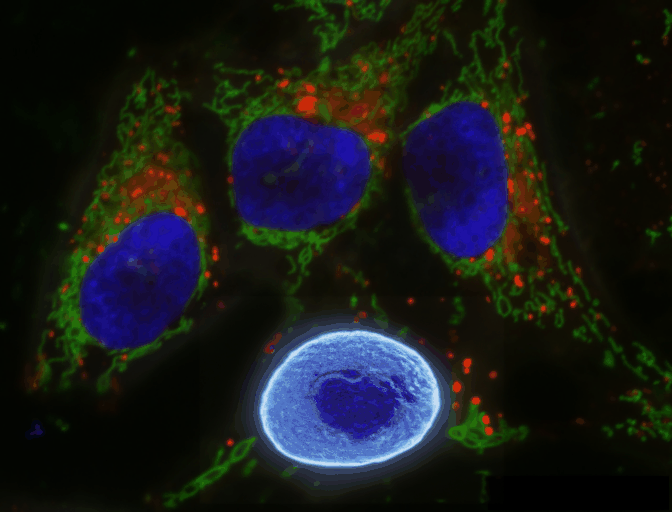

In [8]:
stackview.animate_curtain(input_image, new_image, zoom_factor=0.5)

## Exercise
Apply filters such as the local standard deviation, Sobel or Laplace to the manipulated image and see if you can spot the masked region in the filtered images.

## Exercise

Crop the image so that you can see the border between manipulated region and original image. Zoom in and show only low intensity values.